In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import warnings
import joblib

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import  plot_precision_recall_curve
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes as nb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")


Mounted at /content/gdrive


# PRE-PROCESSING

In [3]:
DataFrame = pd.read_csv("/content/gdrive/My Drive/Credit Card Fraud Detection/Dataset/3 2019- ccFraud.csv")
df = DataFrame.copy()
df.shape 
# no null values

(10000000, 9)

In [4]:
df.head()

,custID,gender,state,cardholder,balance,numTrans,numIntlTrans,creditLine,fraudRisk
0,1,1,35,1,3000,4,14,2,0
1,2,2,2,1,0,9,0,18,0
2,3,2,2,1,0,27,9,16,0
3,4,1,15,1,0,12,0,5,0
4,5,1,46,1,0,11,16,7,0


In [5]:
df.isnull().sum()

custID          0
gender          0
state           0
cardholder      0
balance         0
numTrans        0
numIntlTrans    0
creditLine      0
fraudRisk       0
dtype: int64

In [6]:
df["gender"].value_counts() # 1 = male, 2 = female

1    6178231
2    3821769
Name: gender, dtype: int64

0    9403986
1     596014
Name: fraudRisk, dtype: int64

Fraud: 5.96% 
Legitimate:94.04% 


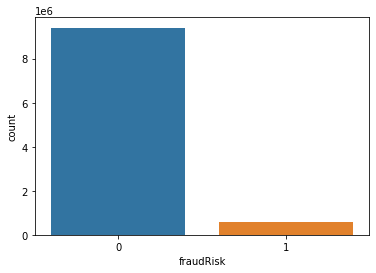

In [7]:
print(df["fraudRisk"].value_counts()) # 0 = Legitimate, 1 = Fraud
print("\nFraud: {:.2f}% ".format((df["fraudRisk"].value_counts()[1] / df.shape[0]) * 100))
print("Legitimate:{:.2f}% ".format((df["fraudRisk"].value_counts()[0] / df.shape[0]) * 100))
sns.countplot(df["fraudRisk"])

In [8]:
df.describe()

,custID,gender,state,cardholder,balance,numTrans,numIntlTrans,creditLine,fraudRisk
count,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07
mean,5.000000e+06,1.382177e+00,2.466127e+01,1.030004e+00,4.109920e+03,2.893519e+01,4.047190e+00,9.134469e+00,5.960140e-02
std,2.886751e+06,4.859195e-01,1.497012e+01,1.705991e-01,3.996847e+03,2.655378e+01,8.602970e+00,9.641974e+00,2.367469e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,2.500001e+06,1.000000e+00,1.000000e+01,1.000000e+00,0.000000e+00,1.000000e+01,0.000000e+00,4.000000e+00,0.000000e+00
50%,5.000000e+06,1.000000e+00,2.400000e+01,1.000000e+00,3.706000e+03,1.900000e+01,0.000000e+00,6.000000e+00,0.000000e+00
75%,7.500000e+06,2.000000e+00,3.800000e+01,1.000000e+00,6.000000e+03,3.900000e+01,4.000000e+00,1.100000e+01,0.000000e+00
max,1.000000e+07,2.000000e+00,5.100000e+01,2.000000e+00,4.148500e+04,1.000000e+02,6.000000e+01,7.500000e+01,1.000000e+00


# Train Test Split

In [9]:
from sklearn.model_selection import train_test_split
X = df.drop(['fraudRisk', 'custID'],axis=1)
y = df[["fraudRisk"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=10)

# Scaling the Data
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train = pd.DataFrame(ss.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(ss.transform(X_test), columns = X_test.columns)

In [10]:
y_train.shape, X_train.shape, X_test.shape, y_test.shape
X_train.isna().sum(), y_train.isnull().sum()

(gender          0
 state           0
 cardholder      0
 balance         0
 numTrans        0
 numIntlTrans    0
 creditLine      0
 dtype: int64, fraudRisk    0
 dtype: int64)

In [11]:
X_test

,gender,state,cardholder,balance,numTrans,numIntlTrans,creditLine
0,-0.786435,-0.979307,-0.175892,-1.028165,-0.298802,-0.354121,-0.325115
1,-0.786435,-1.313315,-0.175892,0.222821,-0.826013,-0.470296,-0.532586
2,1.271560,-1.313315,-0.175892,-1.028165,-0.411776,-0.470296,-0.740056
3,1.271560,-0.979307,-0.175892,-1.028165,2.676170,-0.470296,-0.428851
4,-0.786435,-1.313315,-0.175892,0.360929,1.584092,1.272333,-0.117645
...,...,...,...,...,...,...,...
2999995,-0.786435,0.223120,-0.175892,-0.027376,0.115434,0.575282,-0.636321
2999996,-0.786435,1.291944,-0.175892,-0.948352,-0.788355,-0.470296,-0.221380
2999997,-0.786435,-0.311292,-0.175892,1.147549,0.416698,-0.470296,0.504766
2999998,1.271560,0.690730,-0.175892,-0.720172,-0.600065,-0.470296,0.504766


# Dealing Imbalanced Data

#### SMOTE

In [12]:
# Random Oversampling
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=10)
X_smote, y_smote = sm.fit_resample(X_train, y_train)
X_smote = pd.DataFrame(X_smote, columns = X_train.columns)
y_smote = pd.DataFrame(y_smote, columns=["fraudRisk"])

In [13]:
X_smote

,gender,state,cardholder,balance,numTrans,numIntlTrans,creditLine
0,1.271560,0.089517,-0.175892,0.988924,-0.524749,-0.470296,0.608501
1,-0.786435,-1.380116,-0.175892,-0.527771,0.153092,-0.470296,-0.843791
2,1.271560,0.557127,-0.175892,-1.028165,-0.938986,0.226756,-0.532586
3,-0.786435,0.957936,-0.175892,-0.535277,-0.938986,-0.470296,0.089825
4,-0.786435,-0.044086,-0.175892,-0.027376,1.282829,-0.005595,-0.636321
...,...,...,...,...,...,...,...
13166175,-0.786435,-0.147311,-0.175892,2.491129,-0.209768,-0.470296,1.334648
13166176,1.271560,-1.313315,-0.175892,1.014257,1.839759,0.202268,1.479318
13166177,-0.786435,0.089517,-0.175892,1.967782,0.201574,-0.387514,0.267478
13166178,1.271560,1.369985,-0.175892,0.367578,2.676170,-0.470296,4.014309


1    6583090
0    6583090
Name: fraudRisk, dtype: int64

Fraud: 50.00% 
Legitimate:50.00% 


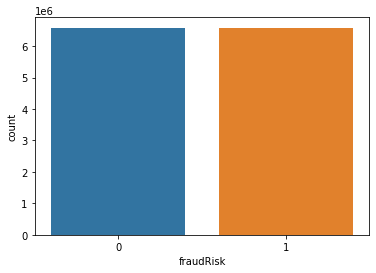

In [14]:
print(y_smote["fraudRisk"].value_counts())
print("\nFraud: {:.2f}% ".format((y_smote["fraudRisk"].value_counts()[1] / y_smote.shape[0]) * 100))
print("Legitimate:{:.2f}% ".format((y_smote["fraudRisk"].value_counts()[0] / y_smote.shape[0]) * 100))
sns.countplot(y_smote["fraudRisk"])
plt.show()

# Model Training

#### Logistic Regression

In [ ]:
model1 =LogisticRegression()
model1.fit(X_smote,y_smote.fraudRisk)
lr_prediction=model1.predict(X_smote)
lr_accuracy = metrics.accuracy_score(lr_prediction,y_smote.fraudRisk)
print(f'Train Data Accuracy= {lr_accuracy*100:.2f}%')

lr_prediction=model1.predict(X_test)
lr_accuracy = metrics.accuracy_score(lr_prediction,y_test[["fraudRisk"]])
print(f'Test Data Accuracy= {lr_accuracy*100:.2f}%')



Train Data Accuracy= 88.82%
Test Data Accuracy= 88.40%


Test Data Confusion Matrix: 


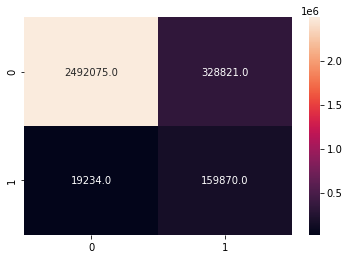

In [ ]:
# confusion matrix of Logistic Regression             Confusion Matrix Format: [TN, FP]      # P = 1, N = 0
print("Test Data Confusion Matrix: ")                 #                        [FN, TP]
sns.heatmap(confusion_matrix(y_test[["fraudRisk"]],lr_prediction), annot=True, fmt=".1f")

In [ ]:
lr_precision = metrics.precision_score(y_test[["fraudRisk"]],lr_prediction)
lr_recall = metrics.recall_score(y_test[["fraudRisk"]],lr_prediction)
lr_f1score = metrics.f1_score(y_test[["fraudRisk"]],lr_prediction)
lr_precision, lr_recall, lr_f1score



(0.327139235222257, 0.8926098802930141, 0.4787996316234773)

In [ ]:
# save the model to disk
filename = '/content/gdrive/My Drive/ML_Credit_Card_Saved_Models/LogisticReg.sav'
joblib.dump(model1, filename)

['/content/gdrive/My Drive/ML_Credit_Card_Saved_Models/LogisticReg.sav']

#### Naive Bayes

In [ ]:
model2 = nb.GaussianNB() 
model2.fit(X_smote,y_smote.fraudRisk)

nb_prediction=model2.predict(X_smote)
nb_accuracy = metrics.accuracy_score(nb_prediction,y_smote.fraudRisk)
print(f'Train Data Accuracy= {nb_accuracy*100:.2f}%')

nb_prediction=model2.predict(X_test)
nb_accuracy = metrics.accuracy_score(nb_prediction,y_test[["fraudRisk"]])
print(f'Test Data Accuracy= {nb_accuracy*100:.2f}%')


Train Data Accuracy= 85.88%
Test Data Accuracy= 86.83%


Test Data Confusion Matrix: 


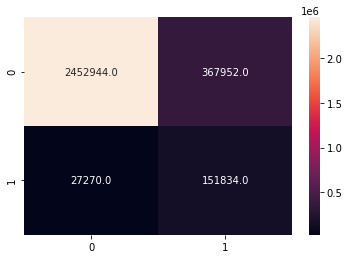

In [ ]:
# confusion matrix of NB
print("Test Data Confusion Matrix: ")
sns.heatmap(confusion_matrix(y_test[["fraudRisk"]],nb_prediction), annot=True, fmt=".1f")

In [ ]:
nb_precision = metrics.precision_score(y_test[["fraudRisk"]],nb_prediction)
nb_recall = metrics.recall_score(y_test[["fraudRisk"]],nb_prediction)
nb_f1score = metrics.f1_score(y_test[["fraudRisk"]],nb_prediction)
nb_precision, nb_recall, nb_f1score


(0.2921086754933761, 0.8477420939789173, 0.4345004220978981)

In [ ]:
# save the model to disk
filename = '/content/gdrive/My Drive/ML_Credit_Card_Saved_Models/NaiveBayes.sav'
joblib.dump(model2, filename)

['/content/gdrive/My Drive/ML_Credit_Card_Saved_Models/NaiveBayes.sav']

#### SGDClassifier algorithm

In [ ]:
model3 =  SGDClassifier()
model3.fit(X_smote,y_smote.fraudRisk)

sgd_prediction=model3.predict(X_smote)
sgd_accuracy = metrics.accuracy_score(sgd_prediction,y_smote.fraudRisk)
print(f'Train Data Accuracy= {sgd_accuracy*100:.2f}%')

sgd_prediction=model3.predict(X_test)
sgd_accuracy = metrics.accuracy_score(sgd_prediction,y_test[["fraudRisk"]])
print(f'Test Data Accuracy= {sgd_accuracy*100:.2f}%')



Train Data Accuracy= 88.86%
Test Data Accuracy= 87.86%


Test Data Confusion Matrix: 


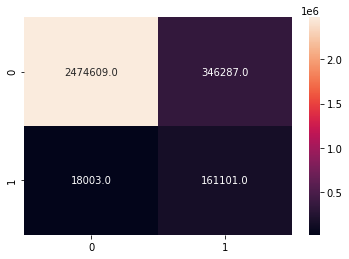

In [ ]:
# confusion matrix of SGDClassifier
print("Test Data Confusion Matrix: ")
sns.heatmap(confusion_matrix(y_test[["fraudRisk"]],sgd_prediction), annot=True, fmt=".1f")

In [ ]:
sgd_precision = metrics.precision_score(y_test[["fraudRisk"]],sgd_prediction)
sgd_recall = metrics.recall_score(y_test[["fraudRisk"]],sgd_prediction)
sgd_f1score = metrics.f1_score(y_test[["fraudRisk"]],sgd_prediction)
sgd_precision, sgd_recall, sgd_f1score



(0.31751046536378474, 0.8994829819546185, 0.46934560053139734)

In [ ]:
# save the model to disk
filename = '/content/gdrive/My Drive/ML_Credit_Card_Saved_Models/SGD.sav'
joblib.dump(model3, filename)

['/content/gdrive/My Drive/ML_Credit_Card_Saved_Models/SGD.sav']

#### Decision Tree

In [ ]:
#KNN algorithm
from sklearn.tree import DecisionTreeClassifier

model4 = DecisionTreeClassifier(criterion = 'entropy', min_samples_split=4)
model4.fit(X_smote,y_smote.fraudRisk)

dt_prediction=model4.predict(X_smote)
dt_prediction = metrics.accuracy_score(dt_prediction,y_smote.fraudRisk)
print(f'Train Data Accuracy= {dt_prediction*100:.2f}%')

dt_prediction=model4.predict(X_test)
dt_accuracy = metrics.accuracy_score(dt_prediction,y_test[["fraudRisk"]])
print(f'Test Data Accuracy= {dt_accuracy*100:.2f}%')



Train Data Accuracy= 98.58%
Test Data Accuracy= 93.26%


Test Data Confusion Matrix: 


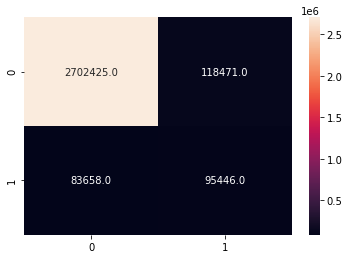

In [ ]:
# confusion matrix of KNN
print("Test Data Confusion Matrix: ")
sns.heatmap(confusion_matrix(y_test[["fraudRisk"]],dt_prediction), annot=True, fmt=".1f")

In [ ]:
dt_precision = metrics.precision_score(y_test[["fraudRisk"]],dt_prediction)
dt_recall = metrics.recall_score(y_test[["fraudRisk"]],dt_prediction)
dt_f1score = metrics.f1_score(y_test[["fraudRisk"]],dt_prediction)
dt_precision, dt_recall, dt_f1score


(0.4461823978458935, 0.5329082544220118, 0.48570432623193166)

In [ ]:
# print(classification_report(y_test[["fraudRisk"]],dt_prediction))

metrics.recall_score(y_test[["fraudRisk"]],dt_prediction)

0.5329082544220118

In [ ]:
# save the model to disk
filename = '/content/gdrive/My Drive/ML_Credit_Card_Saved_Models/DecisionTree.sav'
joblib.dump(model4, filename)

['/content/gdrive/My Drive/ML_Credit_Card_Saved_Models/DecisionTree.sav']

#### Random Forest

In [ ]:
#Random Forest algorithm
from sklearn.ensemble import RandomForestClassifier
model5 = RandomForestClassifier(criterion = 'entropy', n_estimators = 20)
model5.fit(X_smote,y_smote.fraudRisk)

rf_prediction=model5.predict(X_smote)
rf_accuracy = metrics.accuracy_score(rf_prediction,y_smote.fraudRisk)
print(f'Train Data Accuracy= {rf_accuracy*100:.2f}%')

rf_prediction=model5.predict(X_test)
rf_accuracy = metrics.accuracy_score(rf_prediction,y_test[["fraudRisk"]])
print(f'Test Data Accuracy= {rf_accuracy*100:.2f}%')


Train Data Accuracy= 98.86%
Test Data Accuracy= 93.90%


Test Data Confusion Matrix: 


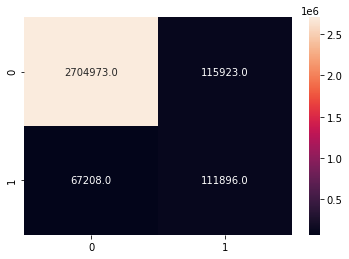

In [ ]:
# confusion matrix of KNN
print("Test Data Confusion Matrix: ")
sns.heatmap(confusion_matrix(y_test[["fraudRisk"]],rf_prediction), annot=True, fmt=".1f")

In [ ]:
rf_precision = metrics.precision_score(y_test[["fraudRisk"]],rf_prediction)
rf_recall = metrics.recall_score(y_test[["fraudRisk"]],rf_prediction)
rf_f1score = metrics.f1_score(y_test[["fraudRisk"]],rf_prediction)
rf_precision, rf_recall, rf_f1score



(0.49116184339322005, 0.6247543326782204, 0.5499615406354519)

In [ ]:
# save the model to disk
filename = '/content/gdrive/My Drive/ML_Credit_Card_Saved_Models/RandomForest.sav'
joblib.dump(model5, filename)

['/content/gdrive/My Drive/ML_Credit_Card_Saved_Models/RandomForest.sav']

In [ ]:
# rf_prediction=model.predict(X_smote)
# rf_prediction1 = metrics.accuracy_score(rf_prediction,y_smote.fraudRisk)
# metrics.average_precision_score(y_smote.fraudRisk,rf_prediction)

#### ANN

In [15]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, PReLU, ELU, Dropout
from tensorflow import keras
from tensorflow.keras import layers


In [16]:
# ANN Model
classifier = keras.Sequential()

# Input Layer
classifier.add(Dense(units = 7, kernel_initializer = 'he_normal', activation = 'relu', input_dim = 7))

# hidden layers
classifier.add(Dense(units = 10, kernel_initializer = 'he_normal', activation = 'relu'))
classifier.add(Dense(units = 25, kernel_initializer = 'he_normal', activation = 'relu'))
classifier.add(Dense(units = 20, kernel_initializer = 'he_normal', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])



In [17]:
classifier.fit(X_smote,y_smote.fraudRisk, validation_split = 0.33, batch_size = 20, epochs = 15)

Epoch 1/15
441067/441067 [==============================] - 785s 2ms/step - loss: 0.2259 - accuracy: 0.9008 - val_loss: 0.4940 - val_accuracy: 0.7723
Epoch 2/15
441067/441067 [==============================] - 782s 2ms/step - loss: 0.2253 - accuracy: 0.9011 - val_loss: 0.4620 - val_accuracy: 0.8011
Epoch 3/15
441067/441067 [==============================] - 782s 2ms/step - loss: 0.2255 - accuracy: 0.9011 - val_loss: 0.4784 - val_accuracy: 0.7868
Epoch 4/15
441067/441067 [==============================] - 796s 2ms/step - loss: 0.2256 - accuracy: 0.9010 - val_loss: 0.4648 - val_accuracy: 0.7978
Epoch 5/15
441067/441067 [==============================] - 792s 2ms/step - loss: 0.2256 - accuracy: 0.9010 - val_loss: 0.5098 - val_accuracy: 0.7699
Epoch 6/15
441067/441067 [==============================] - 733s 2ms/step - loss: 0.2256 - accuracy: 0.9010 - val_loss: 0.4704 - val_accuracy: 0.7929
Epoch 7/15
441067/441067 [==============================] - 786s 2ms/step - loss: 0.2257 - accuracy:

In [18]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (20, 7)                   56        
_________________________________________________________________
module_wrapper_1 (ModuleWrap (20, 10)                  80        
_________________________________________________________________
module_wrapper_2 (ModuleWrap (20, 25)                  275       
_________________________________________________________________
module_wrapper_3 (ModuleWrap (20, 20)                  520       
_________________________________________________________________
module_wrapper_4 (ModuleWrap (20, 1)                   21        
Total params: 952
Trainable params: 952
Non-trainable params: 0
_________________________________________________________________


In [22]:

y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

ANN_pred = pd.DataFrame(y_pred, columns = ['fraudRisk'])
ANN_pred.loc[ANN_pred.fraudRisk == True, 'fraudRisk 01'] = 1
ANN_pred.loc[ANN_pred.fraudRisk == False, 'fraudRisk 01'] = 0
ANN_pred['fraudRisk 01'] = ANN_pred['fraudRisk 01'].astype(np.int64)
ANN_pred = ANN_pred.drop("fraudRisk", axis=1)
ann_accuracy = metrics.accuracy_score(ANN_pred[['fraudRisk 01']],y_test[["fraudRisk"]])
print(f'Accuracy= {ann_accuracy*100:.2f}%')

Accuracy= 92.08%


In [27]:
from keras.models import load_model

classifier.save("/content/gdrive/My Drive/ML_Credit_Card_Saved_Models/ANN", overwrite=True)

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/ML_Credit_Card_Saved_Models/ANN/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/ML_Credit_Card_Saved_Models/ANN/assets


In [15]:
filename = '/content/gdrive/My Drive/ML_Credit_Card_Saved_Models/ANN.sav'
from tensorflow import keras
model = keras.models.load_model(filename)

In [32]:
ann_precision = metrics.precision_score(y_test[["fraudRisk"]],ANN_pred[['fraudRisk 01']])
ann_recall = metrics.recall_score(y_test[["fraudRisk"]],ANN_pred[['fraudRisk 01']])
ann_f1score = metrics.f1_score(y_test[["fraudRisk"]],ANN_pred[['fraudRisk 01']])
ann_precision, ann_recall, ann_f1score

(0.41682115439294853, 0.8184965159907093, 0.5523545414126495)

In [19]:
rf = joblib.load('/content/gdrive/My Drive/ML_Credit_Card_Saved_Models/RandomForest.sav')
rf_prediction = rf.predict(X_test)
sgd = joblib.load('/content/gdrive/My Drive/ML_Credit_Card_Saved_Models/SGD.sav')
sgd_prediction = sgd.predict(X_test)
lr = joblib.load('/content/gdrive/My Drive/ML_Credit_Card_Saved_Models/LogisticReg.sav')
lr_prediction = lr.predict(X_test)
dt = joblib.load('/content/gdrive/My Drive/ML_Credit_Card_Saved_Models/DecisionTree.sav')
dt_prediction = dt.predict(X_test)
nb = joblib.load('/content/gdrive/My Drive/ML_Credit_Card_Saved_Models/NaiveBayes.sav')
nb_prediction = nb.predict(X_test)


# Plotting

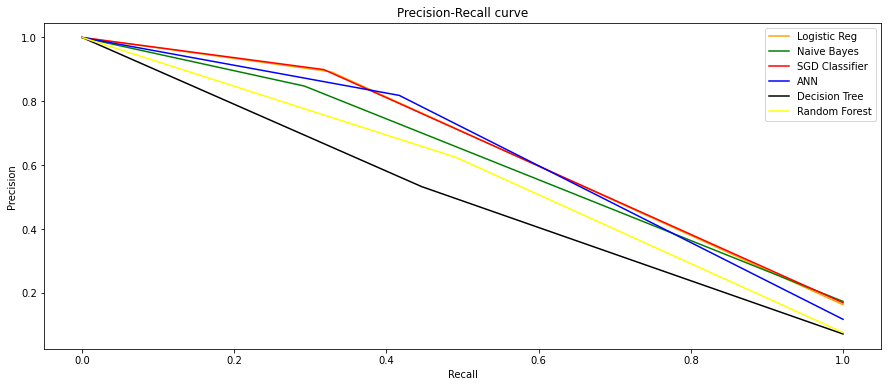

In [20]:
# Precision-Recall Curve
LR_precision1, LR_recall1, _ = precision_recall_curve(lr_prediction, np.array(y_test["fraudRisk"])) # precision, recall, threshold
nb_precision1, nb_recall1, _ = precision_recall_curve(nb_prediction, np.array(y_test["fraudRisk"]))
sgd_precision1, sgd_recall1, _ = precision_recall_curve(sgd_prediction, np.array(y_test["fraudRisk"]))
ann_precision1, ann_recall1, _ = precision_recall_curve(ANN_pred[['fraudRisk 01']], np.array(y_test["fraudRisk"]))
dt_precision1, dt_recall1, _ = precision_recall_curve(dt_prediction, np.array(y_test["fraudRisk"]))
rf_precision1, rf_recall1, _ = precision_recall_curve(rf_prediction, np.array(y_test["fraudRisk"]))

plt.figure(figsize=(15,6))
plt.plot(LR_recall1, LR_precision1, color='orange', label='Logistic Reg')
plt.plot(nb_recall1, nb_precision1, color='green', label='Naive Bayes')
plt.plot(sgd_recall1, sgd_precision1, color='red', label='SGD Classifier')
plt.plot(ann_recall1, ann_precision1, color='blue', label='ANN')
plt.plot(dt_recall1, dt_precision1, color='black', label='Decision Tree')
plt.plot(rf_recall1, rf_precision1, color='yellow', label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()


# Sensitivity(Recall) is a measure of the proportion of actual positive cases that got predicted as positive (or true positive).
# Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.


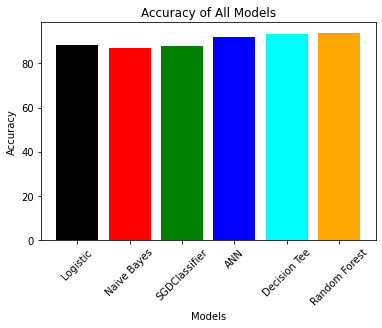

In [36]:
# Accuracy of All Models
plt.bar(['Logistic', 'Naive Bayes', 'SGDClassifier', 'ANN', 'Decision Tee', 'Random Forest'], [lr_accuracy, nb_accuracy, sgd_accuracy, ann_accuracy, dt_accuracy, rf_accuracy], color=['black', 'red', 'green', 'blue', 'cyan', 'orange'])
plt.title('Accuracy of All Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

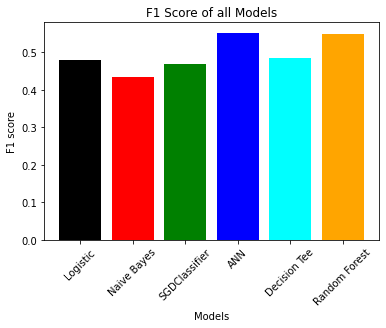

In [37]:
# Plotting F1 Score
plt.bar(['Logistic', 'Naive Bayes', 'SGDClassifier', 'ANN', 'Decision Tee', 'Random Forest'], [lr_f1score, nb_f1score, sgd_f1score, ann_f1score, dt_f1score, rf_f1score], color=['black', 'red', 'green', 'blue', 'cyan', 'orange'])
plt.title('F1 Score of all Models')
plt.xlabel('Models')
plt.ylabel('F1 score')
plt.xticks(rotation=45)
plt.show()

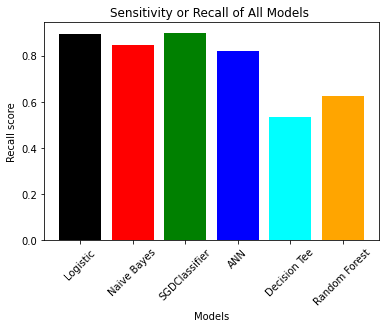

In [38]:
# Plotting Sensitivity or Recall
plt.bar(['Logistic', 'Naive Bayes', 'SGDClassifier', 'ANN', 'Decision Tee', 'Random Forest'], [lr_recall, nb_recall, sgd_recall, ann_recall, dt_recall, rf_recall], color=['black', 'red', 'green', 'blue', 'cyan', 'orange'])
plt.title('Sensitivity or Recall of All Models ')
plt.xlabel('Models')
plt.ylabel('Recall score')
plt.xticks(rotation=45)
plt.show()

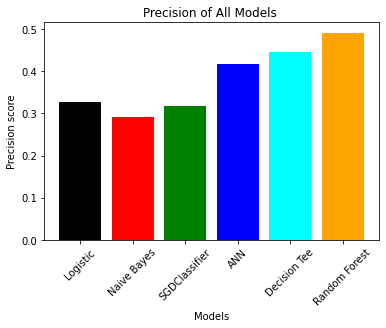

In [39]:
# Plotting Precision
plt.bar(['Logistic', 'Naive Bayes', 'SGDClassifier', 'ANN', 'Decision Tee', 'Random Forest'], [lr_precision, nb_precision, sgd_precision, ann_precision, dt_precision, rf_precision], color=['black', 'red', 'green', 'blue', 'cyan', 'orange'])
plt.title('Precision of All Models ')
plt.xlabel('Models')
plt.ylabel('Precision score')
plt.xticks(rotation=45)
plt.show()